
# 📊 Sesi 4.3 · Statistical Analysis & A/B Testing
Notebook ini mengikuti materi `slides/04_session4_advanced.md` bagian Statistical Analysis.



## 🎯 Tujuan
- Descriptive statistics & distribusi
- Normality check & correlation matrix
- Hypothesis testing (t-test, ANOVA, Chi-square)
- Mini skenario A/B testing dengan interpretasi p-value


In [1]:

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import (shapiro, normaltest, ttest_ind, mannwhitneyu,
                         f_oneway, chi2_contingency)

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')


## 📁 Load Dataset

In [2]:

DATASET_FILENAME = 'RUP-PaketPenyedia-Terumumkan-2025.parquet'
candidate_paths = [
    Path('../../../datasets/rup') / DATASET_FILENAME,
    Path('../../datasets/rup') / DATASET_FILENAME,
    Path('../datasets/rup') / DATASET_FILENAME,
    Path('datasets/rup') / DATASET_FILENAME,
]
for path in candidate_paths:
    if path.exists():
        DATA_PATH = path.resolve()
        break
else:
    raise FileNotFoundError('Dataset RUP 2025 tidak ditemukan. Pastikan folder datasets tersedia.')

df = pd.read_parquet(DATA_PATH)
print(df.shape)

(16430, 48)


In [3]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print('Numeric columns:', numeric_cols)


Numeric columns: ['tahun_anggaran', 'kd_satker', 'kd_rup', 'pagu', 'kd_metode_pengadaan', 'kd_rup_swakelola']


## 1. Descriptive Statistics (Pagu)

In [4]:
if 'pagu' not in df.columns:
    raise ValueError('Kolom pagu tidak ditemukan.')

pagu = df['pagu'].dropna()
summary = pagu.describe()
summary


count    1.643000e+04
mean     1.285250e+08
std      1.217381e+09
min      1.000000e+00
25%      1.360000e+06
50%      8.354500e+06
75%      9.173408e+07
max      7.480242e+10
Name: pagu, dtype: float64

In [5]:
mean_val = pagu.mean()
median_val = pagu.median()
mode_val = pagu.mode().iloc[0] if not pagu.mode().empty else np.nan
variance = pagu.var()
std = pagu.std()
cv = std/mean_val*100
print(f"Mean: {mean_val:,.0f} | Median: {median_val:,.0f} | Mode: {mode_val:,.0f}")
print(f"Std Dev: {std:,.0f} | Variance: {variance:,.0f} | CV: {cv:.2f}%")
for q in [0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99]:
    print(f"P{int(q*100):02d}: {pagu.quantile(q):,.0f}")


Mean: 128,525,020 | Median: 8,354,500 | Mode: 190,000,000
Std Dev: 1,217,381,192 | Variance: 1,482,016,966,612,822,528 | CV: 947.19%
P05: 255,000
P10: 461,900
P25: 1,360,000
P50: 8,354,500
P75: 91,734,075
P90: 190,000,000
P95: 199,602,570
P99: 1,100,000,000


### Distribusi & Central Tendency

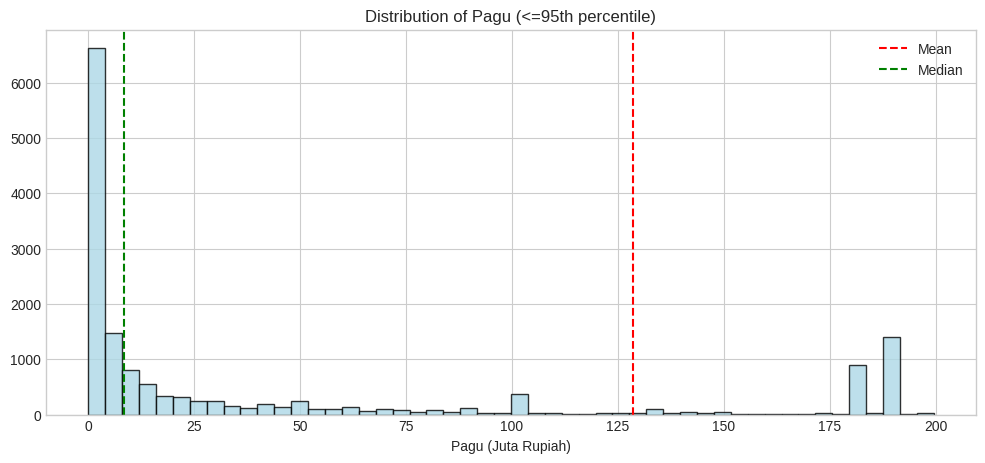

In [6]:
filtered = pagu[pagu < pagu.quantile(0.95)] / 1_000_000
fig, ax = plt.subplots(figsize=(12,5))
ax.hist(filtered, bins=50, color='lightblue', edgecolor='black', alpha=0.8)
ax.axvline(mean_val/1_000_000, color='red', linestyle='--', label='Mean')
ax.axvline(median_val/1_000_000, color='green', linestyle='--', label='Median')
ax.set_xlabel('Pagu (Juta Rupiah)')
ax.set_title('Distribution of Pagu (<=95th percentile)')
ax.legend()
plt.show()


## 2. Normality Checks

In [7]:
sample = pagu.sample(n=5000, random_state=42) if len(pagu) > 5000 else pagu
shapiro_stat, shapiro_p = shapiro(sample)
stat_norm, p_norm = normaltest(sample)
print(f"Shapiro-Wilk p-value: {shapiro_p:.4f}")
print(f"D'Agostino p-value: {p_norm:.4f}")
if shapiro_p < 0.05:
    print('Data tidak berdistribusi normal (reject H0)')
else:
    print('Data terlihat normal (fail to reject H0)')


Shapiro-Wilk p-value: 0.0000
D'Agostino p-value: 0.0000
Data tidak berdistribusi normal (reject H0)


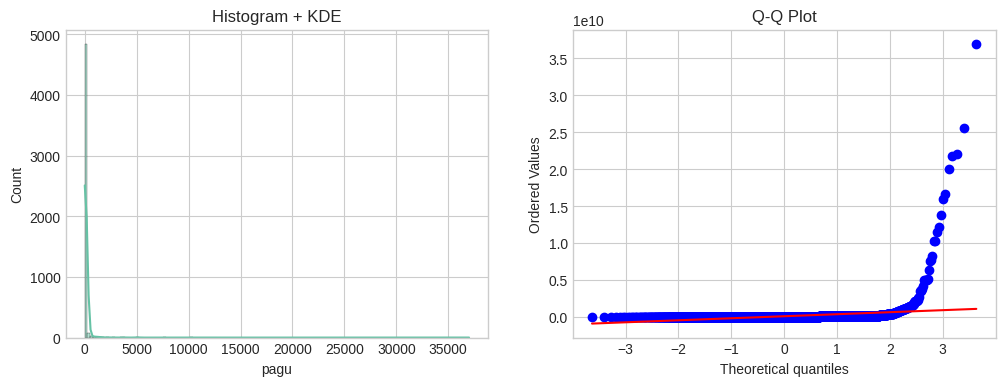

In [8]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.histplot(sample/1_000_000, kde=True, ax=axes[0])
axes[0].set_title('Histogram + KDE')
stats.probplot(sample, dist='norm', plot=axes[1])
axes[1].set_title('Q-Q Plot')
plt.show()


## 3. Correlation Analysis

In [10]:
subset = df[['pagu','kd_satker','kd_metode_pengadaan']].dropna()
pearson_corr = subset.corr(method='pearson')
spearman_corr = subset.corr(method='spearman')
print('Pearson correlation:', pearson_corr)
print('Spearman correlation:', spearman_corr)


Pearson correlation:                          pagu  kd_satker  kd_metode_pengadaan
pagu                 1.000000   0.018286             0.103030
kd_satker            0.018286   1.000000             0.018998
kd_metode_pengadaan  0.103030   0.018998             1.000000
Spearman correlation:                          pagu  kd_satker  kd_metode_pengadaan
pagu                 1.000000  -0.280267            -0.540214
kd_satker           -0.280267   1.000000             0.359841
kd_metode_pengadaan -0.540214   0.359841             1.000000


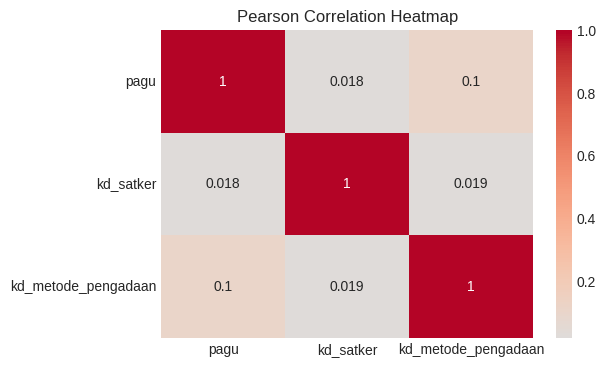

In [11]:
plt.figure(figsize=(6,4))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Pearson Correlation Heatmap')
plt.show()


## 4. Hypothesis Testing Examples

In [12]:
tender = df[df['metode_pengadaan']=='Tender']['pagu'].dropna()
pl = df[df['metode_pengadaan']=='Penunjukan Langsung']['pagu'].dropna()
min_n = min(len(tender), len(pl))
if min_n < 2:
    raise ValueError('Butuh minimal 2 sampel per grup untuk t-test.')

sample_a = tender.sample(min_n, random_state=42)
sample_b = pl.sample(min_n, random_state=42)
t_stat, p_value = ttest_ind(sample_a, sample_b, equal_var=False)
print(f"T-statistic: {t_stat:.4f} | p-value: {p_value:.4f}")
if p_value < 0.05:
    print('Reject H0: rata-rata berbeda signifikan')
else:
    print('Fail to reject H0: tidak ada perbedaan signifikan')

stat_u, p_u = mannwhitneyu(sample_a, sample_b)
print(f"Mann-Whitney U p-value: {p_u:.4f}")


T-statistic: 5.7146 | p-value: 0.0000
Reject H0: rata-rata berbeda signifikan
Mann-Whitney U p-value: 0.0000


In [ ]:

methods = df['metode_pengadaan'].dropna().unique()[:4]
groups = [df[df['metode_pengadaan']==m]['pagu'].dropna() for m in methods]
f_stat, p_val = f_oneway(*groups)
print(f"ANOVA F-stat: {f_stat:.4f} | p-value: {p_val:.4f}")


Chi-square: 15363.83 | p-value: 0.0000 | dof: 28


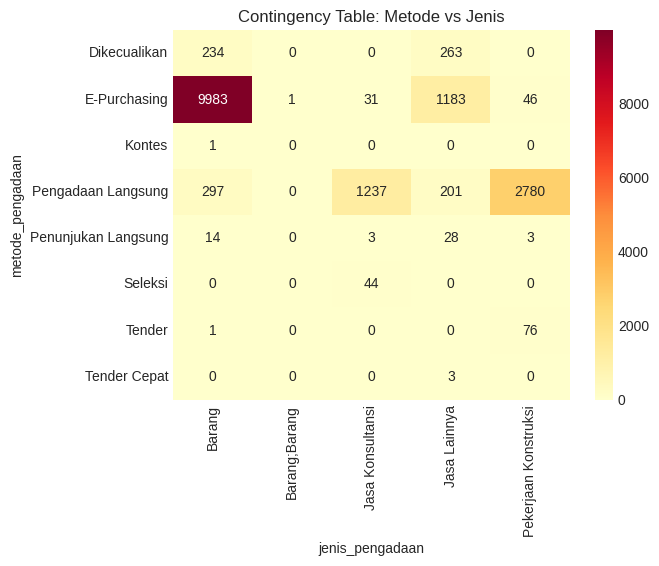

In [13]:
if 'metode_pengadaan' in df.columns and 'jenis_pengadaan' in df.columns:
    contingency = pd.crosstab(df['metode_pengadaan'], df['jenis_pengadaan'])
    chi2, chi_p, dof, expected = chi2_contingency(contingency)
    print(f"Chi-square: {chi2:.2f} | p-value: {chi_p:.4f} | dof: {dof}")
    sns.heatmap(contingency, annot=True, fmt='d', cmap='YlOrRd')
    plt.title('Contingency Table: Metode vs Jenis')
    plt.show()


## 5. Mini A/B Testing Scenario

In [14]:
median_pagu = pagu.median()
df['converted'] = (df['pagu'] > median_pagu).astype(int)
top_methods = df['metode_pengadaan'].value_counts().index[:2]
if len(top_methods) < 2:
    raise ValueError('Butuh minimal 2 metode untuk A/B test.')

A = df[df['metode_pengadaan']==top_methods[0]]
B = df[df['metode_pengadaan']==top_methods[1]]
conv_a = A['converted'].mean()
conv_b = B['converted'].mean()
print(f"Group A ({top_methods[0]}): {conv_a*100:.2f}% conversion")
print(f"Group B ({top_methods[1]}): {conv_b*100:.2f}% conversion")

contingency = pd.DataFrame({
    'Converted': [A['converted'].sum(), B['converted'].sum()],
    'Not Converted': [len(A)-A['converted'].sum(), len(B)-B['converted'].sum()]
}, index=['Group A','Group B'])
chi2, p_ab, _, _ = chi2_contingency(contingency)
print(f"Chi-square p-value: {p_ab:.6f}")
if p_ab < 0.05:
    winner = 'A' if conv_a > conv_b else 'B'
    print(f"Significant difference! Winner: Group {winner}")
else:
    print('Tidak ada perbedaan signifikan.')

lift = (conv_b - conv_a) / conv_a * 100 if conv_a else np.nan
print(f"Lift: {lift:.2f}%")


Group A (E-Purchasing): 31.21% conversion
Group B (Pengadaan Langsung): 94.86% conversion
Chi-square p-value: 0.000000
Significant difference! Winner: Group B
Lift: 203.91%


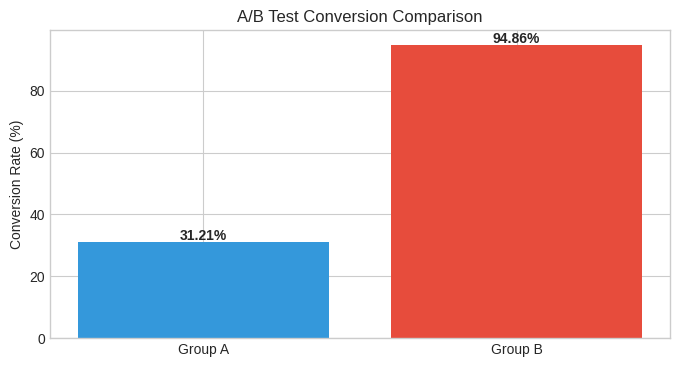

In [15]:
fig, ax = plt.subplots(figsize=(8,4))
ax.bar(['Group A','Group B'], [conv_a*100, conv_b*100], color=['#3498db','#e74c3c'])
ax.set_ylabel('Conversion Rate (%)')
ax.set_title('A/B Test Conversion Comparison')
for idx, val in enumerate([conv_a*100, conv_b*100]):
    ax.text(idx, val+0.5, f"{val:.2f}%", ha='center', fontweight='bold')
plt.show()


## 📋 Summary Report

In [16]:
print('='*70)
print('STATISTICAL ANALYSIS SUMMARY')
print('='*70)
print(summary)
print(f"Skewness: {pagu.skew():.3f} | Kurtosis: {pagu.kurt():.3f}")
print(f"t-test p-value (Tender vs PL): {p_value:.4f}")
print(f"Chi-square p-value (A/B): {p_ab:.4f}")
print('='*70)


STATISTICAL ANALYSIS SUMMARY
count    1.643000e+04
mean     1.285250e+08
std      1.217381e+09
min      1.000000e+00
25%      1.360000e+06
50%      8.354500e+06
75%      9.173408e+07
max      7.480242e+10
Name: pagu, dtype: float64
Skewness: 31.742 | Kurtosis: 1382.014
t-test p-value (Tender vs PL): 0.0000
Chi-square p-value (A/B): 0.0000



## ✅ Key Takeaways
- Periksa distribusi & asumsi sebelum menjalankan uji statistik
- Pilih uji parametrik vs non-parametrik sesuai kondisi data
- P-value < 0.05 = signifikan secara statistik, belum tentu praktis
- A/B testing memerlukan definisi metrik yang jelas (conversion, lift, dsb.)
